# Taller de Calibración de Cámara

En este notebook vamos a calibrar una cámara usando un patrón de tablero de ajedrez.
El objetivo es obtener los parámetros intrínsecos de la cámara y corregir la distorsión del lente.

## Paso 1: Importar librerías necesarias

In [11]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configurar matplotlib para que se vean bien las imágenes
rcParams['figure.figsize'] = (12, 8)
plt.style.use('default')

print("Librerías importadas correctamente")

Librerías importadas correctamente


## Paso 2: Configuración del patrón de tablero

**IMPORTANTE:** Medir el tamaño real de un cuadro con una regla y ajustar el valor de `TAMAÑO_CUADRO`

In [12]:
# Parámetros del tablero de ajedrez
FILAS = 5  # número de esquinas interiores en filas
COLUMNAS = 8  # número de esquinas interiores en columnas
TAMAÑO_CUADRO = 25.0  # tamaño del cuadro en mm (MEDIR CON REGLA!)

print(f"Configuración del tablero:")
print(f"  - Esquinas interiores: {COLUMNAS}x{FILAS}")
print(f"  - Tamaño de cuadro: {TAMAÑO_CUADRO} mm")

Configuración del tablero:
  - Esquinas interiores: 8x5
  - Tamaño de cuadro: 25.0 mm


## Paso 3: Preparar los puntos 3D del tablero

Creamos las coordenadas del tablero en el mundo real (en milímetros)

In [13]:
# Preparar puntos del objeto (coordenadas 3D en el mundo real)
objp = np.zeros((FILAS * COLUMNAS, 3), np.float32)
objp[:, :2] = np.mgrid[0:COLUMNAS, 0:FILAS].T.reshape(-1, 2)
objp = objp * TAMAÑO_CUADRO  # escalar por el tamaño real del cuadro

print(f"Forma de objp: {objp.shape}")
print(f"Primeros 5 puntos 3D del tablero:")
print(objp[:5])

Forma de objp: (40, 3)
Primeros 5 puntos 3D del tablero:
[[  0.   0.   0.]
 [ 25.   0.   0.]
 [ 50.   0.   0.]
 [ 75.   0.   0.]
 [100.   0.   0.]]


## Paso 4: Leer y procesar las imágenes

Buscamos las esquinas del tablero en cada imagen

In [14]:
# Arrays para almacenar los puntos
objpoints = []  # puntos 3D en el mundo real
imgpoints = []  # puntos 2D en las imágenes

# Leer todas las imágenes
ruta_imagenes = 'photos/calibracion/*.png'
imagenes = glob.glob(ruta_imagenes)
print(f"Se encontraron {len(imagenes)} imágenes en la carpeta\n")

if len(imagenes) == 0:
    print(f"⚠️ ERROR: No se encontraron imágenes en '{ruta_imagenes}'")
    print("Verifica la ruta de las imágenes")

Se encontraron 22 imágenes en la carpeta



In [15]:
# Procesar cada imagen para detectar las esquinas
imagenes_con_esquinas = []
imagenes_validas = []
tamaño_img = None

# Criterio de refinamiento de esquinas
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i, fname in enumerate(imagenes):
    print(f"Procesando imagen {i+1}/{len(imagenes)}: {fname.split('/')[-1]}...", end=' ')
    
    img = cv2.imread(fname)
    if img is None:
        print("❌ Error al leer")
        continue
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if tamaño_img is None:
        tamaño_img = gray.shape[::-1]
        print(f"\nTamaño de imagen: {tamaño_img[0]}x{tamaño_img[1]} píxeles")
    
    # Buscar las esquinas del tablero
    ret, esquinas = cv2.findChessboardCorners(gray, (COLUMNAS, FILAS), None)
    
    if ret:
        # Refinar las esquinas para mayor precisión
        esquinas_refinadas = cv2.cornerSubPix(gray, esquinas, (11, 11), (-1, -1), criteria)
        
        objpoints.append(objp)
        imgpoints.append(esquinas_refinadas)
        imagenes_validas.append(fname)
        
        # Dibujar las esquinas en la imagen
        img_con_esquinas = img.copy()
        cv2.drawChessboardCorners(img_con_esquinas, (COLUMNAS, FILAS), esquinas_refinadas, ret)
        imagenes_con_esquinas.append((fname, img_con_esquinas))
        
        print("✅ Esquinas detectadas")
    else:
        print("❌ No se detectaron esquinas")

print(f"\n{'='*60}")
print(f"RESUMEN: {len(imagenes_validas)}/{len(imagenes)} imágenes válidas para calibración")
print(f"{'='*60}")

Procesando imagen 1/22: IMG_0202.png... 
Tamaño de imagen: 1382x1036 píxeles
✅ Esquinas detectadas
Procesando imagen 2/22: IMG_0216.png... ✅ Esquinas detectadas
Procesando imagen 3/22: IMG_0203.png... ✅ Esquinas detectadas
Procesando imagen 4/22: IMG_0215.png... ✅ Esquinas detectadas
Procesando imagen 5/22: IMG_0201.png... ✅ Esquinas detectadas
Procesando imagen 6/22: IMG_0200.png... ✅ Esquinas detectadas
Procesando imagen 7/22: IMG_0210.png... ✅ Esquinas detectadas
Procesando imagen 8/22: IMG_0204.png... ✅ Esquinas detectadas
Procesando imagen 9/22: IMG_0199.png... ✅ Esquinas detectadas
Procesando imagen 10/22: IMG_0198.png... ✅ Esquinas detectadas
Procesando imagen 11/22: IMG_0205.png... ✅ Esquinas detectadas
Procesando imagen 12/22: IMG_0211.png... ✅ Esquinas detectadas
Procesando imagen 13/22: IMG_0207.png... ✅ Esquinas detectadas
Procesando imagen 14/22: IMG_0213.png... ❌ No se detectaron esquinas
Procesando imagen 15/22: IMG_0212.png... ✅ Esquinas detectadas
Procesando imagen 16/

## Paso 5: Visualizar detección de esquinas

Mostramos algunas imágenes con las esquinas detectadas

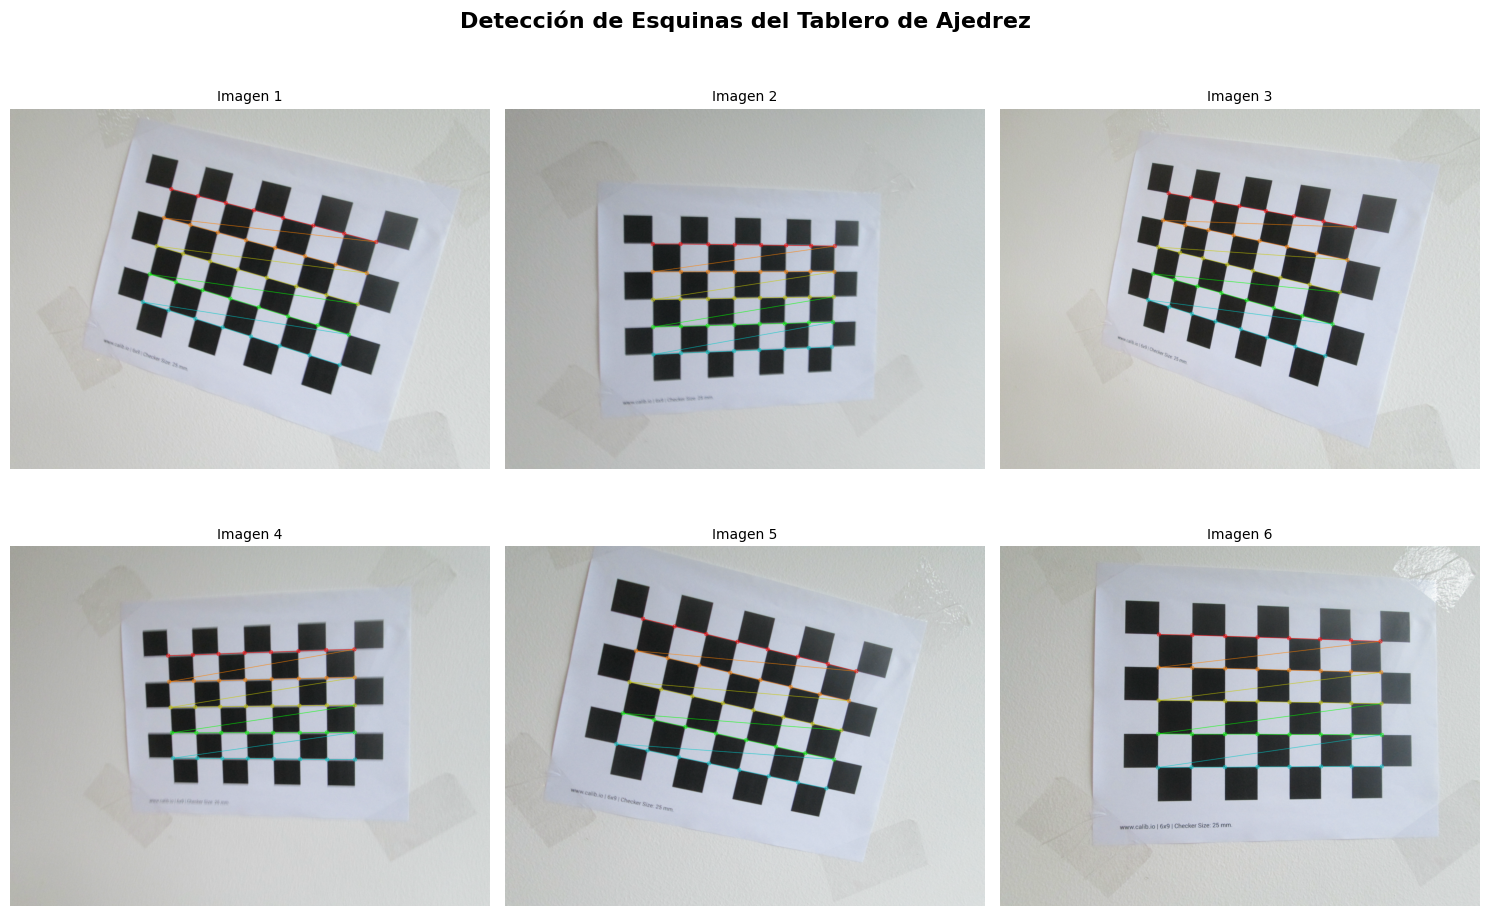

✅ Imagen guardada como '1_esquinas_detectadas.png'


In [16]:
# Mostrar 6 imágenes con esquinas detectadas
num_mostrar = min(6, len(imagenes_con_esquinas))

if num_mostrar > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Detección de Esquinas del Tablero de Ajedrez', fontsize=16, fontweight='bold')
    
    for i in range(num_mostrar):
        fname, img = imagenes_con_esquinas[i]
        ax = axes[i//3, i%3]
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(f'Imagen {i+1}', fontsize=10)
        ax.axis('off')
    
    # Ocultar subplots vacíos si hay menos de 6 imágenes
    for i in range(num_mostrar, 6):
        axes[i//3, i%3].axis('off')
    
    plt.tight_layout()
    plt.savefig('1_esquinas_detectadas.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Imagen guardada como '1_esquinas_detectadas.png'")
else:
    print("⚠️ No hay imágenes con esquinas detectadas para mostrar")

## Paso 6: Calibración de la cámara

Usamos cv2.calibrateCamera() para obtener los parámetros intrínsecos

In [17]:
if len(objpoints) > 0:
    print("Calibrando la cámara...")
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, tamaño_img, None, None
    )
    
    print("\n" + "="*60)
    print("RESULTADOS DE LA CALIBRACIÓN")
    print("="*60)
    
    # Matriz de cámara K
    print("\n📐 MATRIZ DE CÁMARA K:")
    print(mtx)
    print(f"\nParámetros:")
    print(f"  fx (longitud focal en x): {mtx[0,0]:.2f} píxeles")
    print(f"  fy (longitud focal en y): {mtx[1,1]:.2f} píxeles")
    print(f"  cx (punto principal en x): {mtx[0,2]:.2f} píxeles")
    print(f"  cy (punto principal en y): {mtx[1,2]:.2f} píxeles")
    
    # Coeficientes de distorsión
    print("\n🔍 COEFICIENTES DE DISTORSIÓN:")
    print(f"  k1: {dist[0][0]:.8f}")
    print(f"  k2: {dist[0][1]:.8f}")
    print(f"  p1: {dist[0][2]:.8f}")
    print(f"  p2: {dist[0][3]:.8f}")
    print(f"  k3: {dist[0][4]:.8f}")
    
    # Error RMS
    print(f"\n📊 ERROR RMS DE REPROYECCIÓN: {ret:.4f} píxeles")
    if ret < 0.5:
        print("   ✅ Excelente calibración (< 0.5 píxeles)")
    elif ret < 1.0:
        print("   ⚠️ Calibración aceptable (< 1.0 píxeles)")
    else:
        print("   ❌ Calibración pobre (> 1.0 píxeles) - considera tomar más imágenes")
    
    print("="*60)
    
    # Guardar parámetros
    np.savez('calibracion_camara.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)
    print("\n💾 Parámetros guardados en 'calibracion_camara.npz'")
    
else:
    print("❌ ERROR: No se detectaron esquinas en ninguna imagen")
    print("No se puede realizar la calibración")

Calibrando la cámara...

RESULTADOS DE LA CALIBRACIÓN

📐 MATRIZ DE CÁMARA K:
[[1.40046724e+03 0.00000000e+00 6.95239086e+02]
 [0.00000000e+00 1.39689995e+03 5.28094458e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Parámetros:
  fx (longitud focal en x): 1400.47 píxeles
  fy (longitud focal en y): 1396.90 píxeles
  cx (punto principal en x): 695.24 píxeles
  cy (punto principal en y): 528.09 píxeles

🔍 COEFICIENTES DE DISTORSIÓN:
  k1: -0.05060224
  k2: 0.13675724
  p1: 0.00489105
  p2: 0.00107254
  k3: -0.36154323

📊 ERROR RMS DE REPROYECCIÓN: 0.4400 píxeles
   ✅ Excelente calibración (< 0.5 píxeles)

💾 Parámetros guardados en 'calibracion_camara.npz'


## Paso 7: Corrección de distorsión

Aplicamos la calibración para corregir la distorsión en las imágenes

Generando imágenes corregidas...

✅ Procesada imagen 1
✅ Procesada imagen 2
✅ Procesada imagen 3


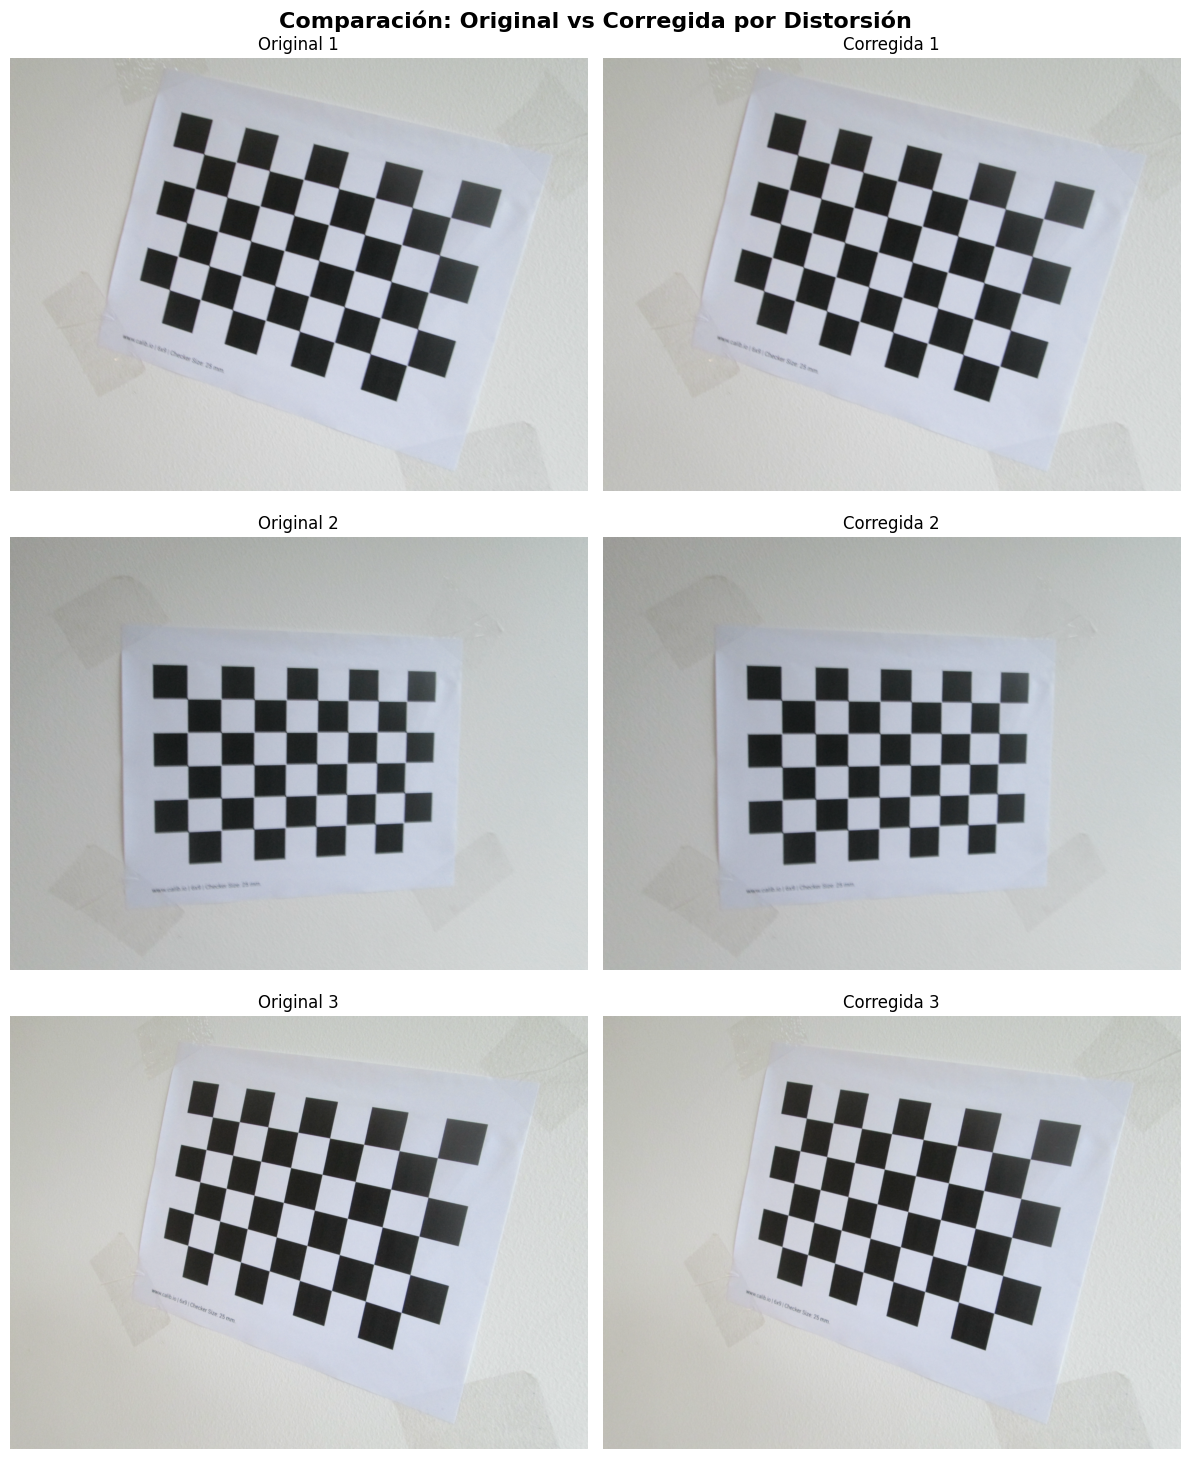


💾 Imagen guardada como '2_comparacion_distorsion.png'


In [19]:
if len(objpoints) > 0:
    print("Generando imágenes corregidas...\n")
    
    # Seleccionar 3 imágenes para mostrar
    num_comparaciones = min(3, len(imagenes_validas))
    
    fig, axes = plt.subplots(num_comparaciones, 2, figsize=(12, 5*num_comparaciones))
    if num_comparaciones == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Comparación: Original vs Corregida por Distorsión', fontsize=16, fontweight='bold')
    
    for i in range(num_comparaciones):
        img = cv2.imread(imagenes_validas[i])
        h, w = img.shape[:2]
        
        # Obtener la matriz de cámara óptima
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
        
        # Corregir distorsión
        img_corregida = cv2.undistort(img, mtx, dist, None, newcameramtx)
        
        # Recortar según ROI
        x, y, w_roi, h_roi = roi
        img_corregida_recortada = img_corregida[y:y+h_roi, x:x+w_roi]
        
        # Mostrar original
        axes[i, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f'Original {i+1}', fontsize=12)
        axes[i, 0].axis('off')
        
        # Mostrar corregida
        axes[i, 1].imshow(cv2.cvtColor(img_corregida_recortada, cv2.COLOR_BGR2RGB))
        axes[i, 1].set_title(f'Corregida {i+1}', fontsize=12)
        axes[i, 1].axis('off')
        
        print(f"✅ Procesada imagen {i+1}")
    
    plt.tight_layout()
    plt.savefig('2_comparacion_distorsion.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n💾 Imagen guardada como '2_comparacion_distorsion.png'")

## Paso 8: Análisis de los resultados

Respondemos las preguntas del reporte

In [20]:
if len(objpoints) > 0:
    print("\n" + "="*70)
    print("ANÁLISIS DETALLADO PARA EL REPORTE")
    print("="*70)
    
    # Extraer parámetros
    fx, fy = mtx[0,0], mtx[1,1]
    cx, cy = mtx[0,2], mtx[1,2]
    k1, k2, p1, p2, k3 = dist[0]
    
    # 1. Tipo de distorsión
    print("\n1️⃣ TIPO DE DISTORSIÓN PREDOMINANTE:")
    if k1 < 0:
        print(f"   → DISTORSIÓN DE BARRIL")
        print(f"   k1 = {k1:.6f} (negativo)")
        print("   ")
        print("   Características:")
        print("   - Las líneas rectas se curvan hacia afuera")
        print("   - Las esquinas de la imagen se ven 'infladas'")
        print("   - Común en cámaras de celular y lentes gran angular")
    else:
        print(f"   → DISTORSIÓN DE COJÍN (pincushion)")
        print(f"   k1 = {k1:.6f} (positivo)")
        print("   ")
        print("   Características:")
        print("   - Las líneas rectas se curvan hacia adentro")
        print("   - Las esquinas se ven 'comprimidas'")
        print("   - Común en lentes teleobjetivo")
    
    if abs(k1) > 0.2:
        nivel = "MUY FUERTE"
    elif abs(k1) > 0.1:
        nivel = "FUERTE"
    elif abs(k1) > 0.05:
        nivel = "MODERADA"
    else:
        nivel = "LEVE"
    print(f"   Nivel de distorsión: {nivel}")
    
    # 2. Comparación fx vs fy
    print("\n2️⃣ COMPARACIÓN DE fx Y fy:")
    diferencia = abs(fx - fy)
    porcentaje_dif = (diferencia / fx) * 100
    print(f"   fx = {fx:.2f} píxeles")
    print(f"   fy = {fy:.2f} píxeles")
    print(f"   Diferencia: {diferencia:.2f} píxeles ({porcentaje_dif:.2f}%)")
    print()
    
    if porcentaje_dif < 1:
        print("   ✅ Los valores son MUY SIMILARES")
        print("   ")
        print("   Interpretación:")
        print("   - Los píxeles del sensor son prácticamente cuadrados")
        print("   - No hay anamorfismo en el lente")
        print("   - La relación de aspecto es correcta")
    elif porcentaje_dif < 5:
        print("   ⚠️ Hay una pequeña diferencia")
        print("   ")
        print("   Posibles causas:")
        print("   - Pequeña diferencia en el espaciado de píxeles")
        print("   - Efecto de compresión o procesamiento de imagen")
        print("   - Imperfecciones menores del lente")
    else:
        print("   ❌ Hay una diferencia significativa")
        print("   ")
        print("   Posibles causas:")
        print("   - Píxeles rectangulares en el sensor")
        print("   - Redimensionamiento no uniforme de la imagen")
        print("   - Anamorfismo intencional del lente")
    
    # 3. Ubicación del punto principal
    print("\n3️⃣ UBICACIÓN DEL PUNTO PRINCIPAL:")
    centro_img_x = tamaño_img[0] / 2
    centro_img_y = tamaño_img[1] / 2
    
    print(f"   Centro geométrico de la imagen: ({centro_img_x:.2f}, {centro_img_y:.2f})")
    print(f"   Punto principal calibrado (cx, cy): ({cx:.2f}, {cy:.2f})")
    print()
    
    desvio_x = cx - centro_img_x
    desvio_y = cy - centro_img_y
    desvio_total = np.sqrt(desvio_x**2 + desvio_y**2)
    
    print(f"   Desviación en X: {desvio_x:+.2f} píxeles")
    print(f"   Desviación en Y: {desvio_y:+.2f} píxeles")
    print(f"   Desviación total: {desvio_total:.2f} píxeles")
    print()
    
    porcentaje_desvio = (desvio_total / tamaño_img[0]) * 100
    
    if porcentaje_desvio < 2:
        print("   ✅ El punto principal está MUY CERCA del centro")
        print("   ")
        print("   Interpretación:")
        print("   - El eje óptico del lente está bien alineado con el sensor")
        print("   - Buena calidad de ensamblaje de la cámara")
    elif porcentaje_desvio < 5:
        print("   ⚠️ El punto principal tiene un pequeño desplazamiento")
        print("   ")
        print("   Interpretación:")
        print("   - Ligera desalineación entre lente y sensor")
        print("   - Puede ser por recorte digital de la imagen")
    else:
        print("   ❌ El punto principal está NOTABLEMENTE desplazado")
        print("   ")
        print("   Posibles causas:")
        print("   - Desalineación significativa del lente")
        print("   - Recorte o zoom digital aplicado")
        print("   - Sensor descentrado")
    
    print("\n" + "="*70)


ANÁLISIS DETALLADO PARA EL REPORTE

1️⃣ TIPO DE DISTORSIÓN PREDOMINANTE:
   → DISTORSIÓN DE BARRIL
   k1 = -0.050602 (negativo)
   
   Características:
   - Las líneas rectas se curvan hacia afuera
   - Las esquinas de la imagen se ven 'infladas'
   - Común en cámaras de celular y lentes gran angular
   Nivel de distorsión: MODERADA

2️⃣ COMPARACIÓN DE fx Y fy:
   fx = 1400.47 píxeles
   fy = 1396.90 píxeles
   Diferencia: 3.57 píxeles (0.25%)

   ✅ Los valores son MUY SIMILARES
   
   Interpretación:
   - Los píxeles del sensor son prácticamente cuadrados
   - No hay anamorfismo en el lente
   - La relación de aspecto es correcta

3️⃣ UBICACIÓN DEL PUNTO PRINCIPAL:
   Centro geométrico de la imagen: (691.00, 518.00)
   Punto principal calibrado (cx, cy): (695.24, 528.09)

   Desviación en X: +4.24 píxeles
   Desviación en Y: +10.09 píxeles
   Desviación total: 10.95 píxeles

   ✅ El punto principal está MUY CERCA del centro
   
   Interpretación:
   - El eje óptico del lente está bie

## Paso 9: Visualización del modelo de distorsión

Creamos una cuadrícula para visualizar cómo la distorsión afecta la imagen

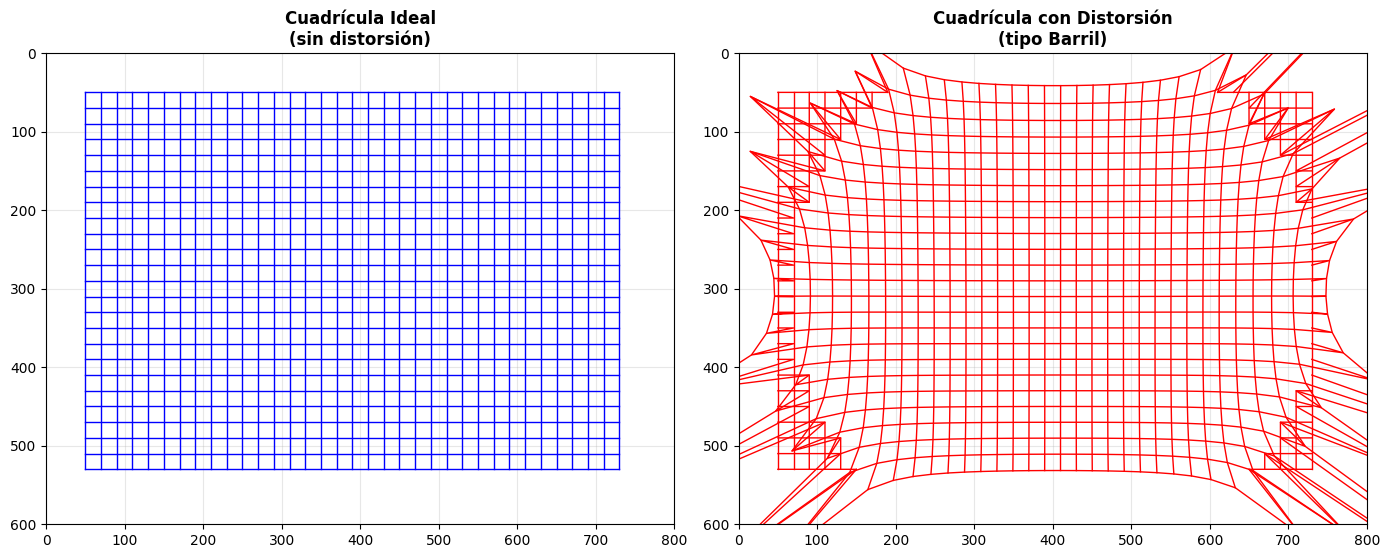

✅ Visualización guardada como '3_modelo_distorsion.png'

Observa cómo las líneas rectas de la cuadrícula ideal se curvan
en la cuadrícula con distorsión, especialmente en las esquinas.


In [21]:
if len(objpoints) > 0:
    # Crear una cuadrícula regular
    h_grid, w_grid = 600, 800
    puntos_y, puntos_x = np.mgrid[50:h_grid-50:20, 50:w_grid-50:20].astype(np.float32)
    puntos_originales = np.stack([puntos_x.ravel(), puntos_y.ravel()], axis=1).reshape(-1, 1, 2)
    
    # Crear matriz de cámara ficticia para visualización
    K_ficticia = np.array([
        [w_grid/2, 0, w_grid/2],
        [0, w_grid/2, h_grid/2],
        [0, 0, 1]
    ], dtype=np.float32)
    
    # Aplicar el modelo de distorsión
    puntos_distorsionados = cv2.undistortPoints(puntos_originales, K_ficticia, dist, None, K_ficticia)
    
    # Crear la figura
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Cuadrícula ideal (sin distorsión)
    ax1 = axes[0]
    x_orig = puntos_originales[:, 0, 0].reshape(puntos_x.shape)
    y_orig = puntos_originales[:, 0, 1].reshape(puntos_y.shape)
    
    for i in range(x_orig.shape[0]):
        ax1.plot(x_orig[i, :], y_orig[i, :], 'b-', linewidth=1)
    for j in range(x_orig.shape[1]):
        ax1.plot(x_orig[:, j], y_orig[:, j], 'b-', linewidth=1)
    
    ax1.set_title('Cuadrícula Ideal\n(sin distorsión)', fontsize=12, fontweight='bold')
    ax1.set_xlim(0, w_grid)
    ax1.set_ylim(h_grid, 0)
    ax1.set_aspect('equal')
    ax1.grid(True, alpha=0.3)
    
    # Cuadrícula con distorsión
    ax2 = axes[1]
    x_dist = puntos_distorsionados[:, 0, 0].reshape(puntos_x.shape)
    y_dist = puntos_distorsionados[:, 0, 1].reshape(puntos_y.shape)
    
    for i in range(x_dist.shape[0]):
        ax2.plot(x_dist[i, :], y_dist[i, :], 'r-', linewidth=1)
    for j in range(x_dist.shape[1]):
        ax2.plot(x_dist[:, j], y_dist[:, j], 'r-', linewidth=1)
    
    tipo_dist = "Barril" if k1 < 0 else "Cojín"
    ax2.set_title(f'Cuadrícula con Distorsión\n(tipo {tipo_dist})', fontsize=12, fontweight='bold')
    ax2.set_xlim(0, w_grid)
    ax2.set_ylim(h_grid, 0)
    ax2.set_aspect('equal')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('3_modelo_distorsion.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualización guardada como '3_modelo_distorsion.png'")
    print("\nObserva cómo las líneas rectas de la cuadrícula ideal se curvan")
    print("en la cuadrícula con distorsión, especialmente en las esquinas.")